In [1]:
%store -r machine_data

In [4]:
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/commands/install.py", line 483, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in version
    return parse_version(self._

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( classification_report, confusion_matrix, roc_auc_score, roc_curve )
import matplotlib.pyplot as plt

In [7]:
X = machine_data.drop(columns='Health_status')
y = machine_data['Health_status'].astype(int)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


In [10]:
print(scale_pos_weight)

3.3796653796653797


In [17]:
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [18]:
xgb.fit(X_train, y_train)


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [19]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

In [20]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       657
           1       0.43      0.37      0.40       194

    accuracy                           0.75       851
   macro avg       0.63      0.61      0.62       851
weighted avg       0.73      0.75      0.74       851

Confusion Matrix:
 [[563  94]
 [122  72]]
AUC Score: 0.6922


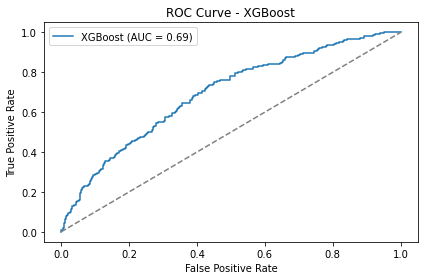

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.tight_layout()
plt.show()